In [47]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# import torch
# assert torch.cuda.is_available(), "GPU not available"

In [50]:
torch.cuda.is_available()

False

In [51]:
!pip install light-the-torch >> /.tmp
!ltt install torch torchvision >> /.tmp
!pip install fastai --upgrade >> /.tmp

In [52]:
# import zipfile
# import os

# def unzip_file(zip_file_path, extract_to_folder):
#     # Ensure the target directory exists
#     os.makedirs(extract_to_folder, exist_ok=True)

#     # Open and extract the ZIP file
#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_to_folder)

#     print(f"Files extracted to {extract_to_folder}")

# # Usage
# zip_file_path = '/content/drive/MyDrive/Colab Notebooks/test.zip'  # Replace with the path to your ZIP file
# extract_to_folder = '/content/drive/MyDrive/Colab Notebooks'  # Replace with the target directory for extraction
# unzip_file(zip_file_path, extract_to_folder)

In [53]:
train_labels_path = "/content/drive/MyDrive/Colab Notebooks/written_name_train_v2.csv"
test_labels_path = "/content/drive/MyDrive/Colab Notebooks/written_name_test_v2.csv"
training_folder_path = "/content/drive/MyDrive/Colab Notebooks/train/train"
testing_folder_path = "/content/drive/MyDrive/Colab Notebooks/test"

In [54]:
BATCH_SIZE = 1

In [55]:
num_classes=28
LABELS = {'`':0,"ka":1,"kha":2, 'ga': 3, 'gha': 4, 'ca': 5, 'ja': 6, 'ta': 7, 'da': 8, 'na': 9, 'ba': 10, 'va': 11, 'ha': 12, 'metro': 13, 'dhaka': 14, 'khulna': 15, 'chattogram': 16, 'jashore': 17, '0': 18, '1': 19, '2': 20, '3': 21, '4': 22, '5': 23, '6': 24, '7': 25,'8':26,'9':27}

In [56]:
in_channels=1
img_width = 160
img_height = 20

In [57]:
num_patches = 8

In [58]:
# """This denotes height and width of each patch.Also remember
# img_height*img_width*in_channels = num_patches*embedding_dim"""
patch_size= 20
embedding_dim=400 # img_width*img_height/(num_patches)

In [59]:
encoder_num_heads =1
encoder_mlp_size=64
encoder_num_layers=4

In [60]:
decoder_num_heads =1
decoder_mlp_size=64
decoder_num_layers=4

In [61]:
epochs = 5
training_data = []
testing_data = []
training_tuple = []
testing_tuple = []

In [62]:
class myDataLoader():
    TRAIN_CSV = pd.read_csv(train_labels_path)
    TEST_CSV = pd.read_csv(test_labels_path)
    IMG_Width=img_width
    IMG_Height=img_height
    TRAINING_FOLDER = training_folder_path
    TESTING_FOLDER = testing_folder_path

    def make_training_data(self):
        for f in tqdm(os.listdir(self.TRAINING_FOLDER)):
             try:
                path = os.path.join(self.TRAINING_FOLDER, f)  #conplete path of file
                training_data.append(path)
             except Exception as e:
                pass

        for i in range(3480):
            if self.TRAIN_CSV['Names'][i] != self.TRAIN_CSV['Names'][i]:  #true when self.TRAIN_CSV['IDENTITY'][i] is empty
              continue
            training_tuple.append([training_data[i],self.TRAIN_CSV['Names'][i]])

    def make_testing_data(self):
        for f in tqdm(os.listdir(self.TESTING_FOLDER)):
             try:
                path = os.path.join(self.TESTING_FOLDER, f)  #conplete path of file
                testing_data.append(path)
             except Exception as e:
                pass
        for i in range(218):
            if self.TEST_CSV['Names'][i] != self.TEST_CSV['Names'][i]: #true when self.TEST_CSV['IDENTITY'][i] is empty
              continue
            testing_tuple.append([testing_data[i],self.TEST_CSV['Names'][i]])

In [63]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=1,
               patch_size:int=patch_size,
               embedding_dim:int=embedding_dim):
    super().__init__()

    self.patch_size = patch_size

    """Notice that stride and kernel_size both are equal to patch_size.To get intuition you may see what all these parameters are."""
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    self.flatten = nn.Flatten(start_dim=1,
                              end_dim=2)

  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    x_patched = self.patcher(torch.tensor(x,dtype = torch.float32))
    x_flattened = self.flatten(x_patched)
    # Make the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0, 2, 1).type(torch.float32)

In [64]:
class DecoderLayer(nn.Module):
  def __init__(self,embed_dim:int=embedding_dim,num_heads:int=decoder_num_heads,batch_first=True,dropout=0.1,mlp_size:int=decoder_mlp_size):
    super().__init__()
    """Initializing object queries with all elements equal to 0 and size 1*8*400"""
    self.object_queries = torch.zeros(BATCH_SIZE,8,embed_dim)  # 8 = num_patches
    self.tgt_mask=None

    """self attention block of decoder"""
    self.multiHeadAttention1 = nn.MultiheadAttention(embed_dim=embed_dim,
                                                    num_heads = num_heads,
                                                    batch_first=batch_first,
                                                    dropout = dropout)

    self.layerNorm = nn.LayerNorm(normalized_shape=embed_dim)

    """cross attention block of decoder"""
    self.multiHeadAttention2 = nn.MultiheadAttention(embed_dim=embed_dim,
                                                    num_heads = num_heads,
                                                    batch_first=batch_first,
                                                    dropout = dropout)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embed_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embed_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self,encoder_output,positional_encoding):
    mHA1 = self.multiHeadAttention1(query=self.object_queries+self.object_queries,
                              key=self.object_queries+self.object_queries,
                              value=self.object_queries,
                              need_weights=False)[0]
    ln1 = self.layerNorm(mHA1) + self.object_queries

    mHA2, _ = self.multiHeadAttention2(query=ln1+self.object_queries,
                                    key=positional_encoding+encoder_output,
                                    value=encoder_output,
                                    need_weights=False)
    ln2 = self.layerNorm(mHA2)+ln1

    mlp1 = self.mlp(ln2)
    output = self.layerNorm(mlp1)+ln2
    return output

In [65]:
class Decoder(nn.Module):
  def __init__(self,num_layers=decoder_num_layers):
    super().__init__()

    self.layers = nn.ModuleList(
      [
          DecoderLayer(embed_dim=embedding_dim,num_heads=decoder_num_heads,batch_first=True,dropout=0.1,mlp_size=decoder_mlp_size)
          for _ in range(num_layers)
      ]
    )

    """finally using linear layer to have outfeatures equal to number of classes"""
    self.linearLayer=nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)

  def forward(self,encoder_output,positional_encoding):
    for layer in self.layers:
      x = layer(encoder_output,positional_encoding)

    return self.linearLayer(x)

In [66]:
class Model(nn.Module):
    def __init__(self,
               img_width:int=img_width,
               img_height:int=img_height,
               in_channels:int=in_channels,
               patch_size:int=patch_size,
               num_transformer_layers:int=encoder_num_layers,
               embedding_dim:int=embedding_dim,
               mlp_size:int=encoder_mlp_size,
               num_heads:int=encoder_num_heads,
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=num_classes): # number of classes
        super().__init__()

        self.num_patches = num_patches

        self.patch_embedding = PatchEmbedding(in_channels=1,patch_size=patch_size,embedding_dim=embedding_dim)

        self.positional_embedding = nn.Parameter(torch.randn(1,self.num_patches,embedding_dim))

        self.dropout = nn.Dropout(p=embedding_dropout)

        """used in built transformer encoder of pytorch because its same as that of "Atention is all you need" """
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                         nhead = num_heads,
                                                         dim_feedforward=mlp_size,
                                                         dropout=0.1,
                                                         activation = "gelu",
                                                         batch_first=True,
                                                         norm_first=True),num_layers=num_transformer_layers)

        self.decoder = Decoder()

    def forward(self,input):
        batch_size = input.shape[0]
        x = self.patch_embedding(input)

        x = self.positional_embedding + x

        x = self.dropout(x)

        x = self.transformer_encoder(x)

        x=self.decoder(x,self.patch_embedding(input))

        return x



In [67]:
def acc_fn(y_preds,y_blob_test):
    count = 0
    for i in range(len(y_preds)):
        if y_preds[i] in [y_blob_test[i]-1,y_blob_test[i],y_blob_test[i]+1]:
            count+=1
    return count
test_acc = []
final_testing_loss = []
final_training_loss = []
train_acc = []

In [68]:
class Train_Test():

    def __init__(self,epochs:int = epochs):
        self.EPOCHS = epochs
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(params=model.parameters(),
                                lr=0.0001)
    def train(self):
        for epoch in range(self.EPOCHS):
            print(f"Epoch: {epoch}\n------")
            train_loss = 0
            correct=0
            for batch, (str_path, y_tuple) in (enumerate(train_dataloader)):

                """making X from file paths"""
                X = []
                for k in range(len(str_path)):
                  img = cv2.imread(os.path.normpath(str_path[k]), cv2.IMREAD_GRAYSCALE)
                  img = cv2.resize(img, (img_width, img_height))
                  X.append(img)

                X = torch.tensor(X)
                model.train()
                y_pred =    model(X.unsqueeze(1))

                """making Y suitable with X as Y should only contain data which is in dictionary named LABELS"""
                y = [[]]
                for i in range(len(y_tuple)):
                    for j in range(min(len(y_pred[i]),len(y_tuple[i]))):
                        if not(y_tuple[i][j] in LABELS):
                            y[i].append(LABELS['`'])
                            continue
                        y[i].append(LABELS[y_tuple[i][j]])
                    for j in range(len(y_pred[i])//2-len(y_tuple[i])//2):
                        y[i].append(LABELS['`'])
                        if len(y[i]) < len(y_pred[i]):
                            y[i].insert(0,LABELS['`'])
                    y.append([])
                y.pop()

                y = torch.tensor(y)
                batch_loss = 0

                """train loop"""
                for i in range(len(y)):
                    loss = self.loss_fn(y_pred[i,:,:]*27,y[i,:])
                    correct += acc_fn(y_pred[i,:,:].argmax(dim=1),y[i,:])
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    train_loss+=loss
                    batch_loss = loss

                if batch % 10000 == 0:
                    # training_loss_list.append(batch_loss)
                    print(f"{epoch} Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

            train_loss /= len(train_dataloader)
            print(correct/(len(train_dataloader)*8))
            print(train_loss)
            final_training_loss.append(train_loss)
            train_acc.append(correct/(len(train_dataloader)*8))

            # test_loop
            if (epoch+1)%2 == 0:
                test_loss = 0
                correct = 0
                for batch, (str_path, y_tuple) in (enumerate(test_dataloader)):
                    X = []
                    for k in range(len(str_path)):
                        img = cv2.imread(os.path.normpath(str_path[k]), cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (img_width, img_height))
                        X.append(img)

                    X = torch.tensor(X)
                    model.eval()
                    y_pred = model(X.unsqueeze(1))

                    y = [[]]
                    for i in range(len(y_tuple)):
                        for j in range(min(len(y_pred[i]),len(y_tuple[i]))):
                            if not(y_tuple[i][j] in LABELS):
                                y[i].append(LABELS['`'])
                                continue
                            y[i].append(LABELS[y_tuple[i][j]])
                        for j in range(len(y_pred[i])//2-len(y_tuple[i])//2):
                            y[i].append(LABELS['`'])
                            if len(y[i]) < len(y_pred[i]):
                                y[i].insert(0,LABELS['`'])
                        y.append([])
                    y.pop()

                    y = torch.tensor(y)
                    batch_loss = 0
                    with torch.inference_mode():
                        for i in range(len(y)):
                            loss = self.loss_fn(y_pred[i,:,:]*27,y[i,:])
                            test_loss+=loss
                            batch_loss = loss
                            correct += acc_fn(y_pred[i,:,:].argmax(dim=1),y[i,:])

                    if batch%10000 == 0:
                        print(batch)
                print(correct/(len(test_dataloader)*8),test_loss/len(test_dataloader))
                test_acc.append(correct/(len(test_dataloader)*8))
                final_testing_loss.append(test_loss/len(test_dataloader))

In [69]:
if __name__ == "__main__":
    dataLoader = myDataLoader()
    dataLoader.make_training_data()
    dataLoader.make_testing_data()

    # Turn datasets into iterables (batches)
    train_dataloader = DataLoader(dataset=training_tuple,
                                batch_size=BATCH_SIZE,
                                shuffle=False)

    test_dataloader = DataLoader(dataset=testing_tuple,
                                batch_size=BATCH_SIZE,
                                shuffle=False)

    print(train_dataloader, test_dataloader)
    torch.manual_seed(42)
    model =Model()
    print(model)
    train =Train_Test()
    train.train()
    # plt.plot([ i for i in range(len(training_loss_list))], np.array(torch.tensor(training_loss_list).numpy()), label="Train loss")
    # plt.title("Training loss curves")
    # plt.ylabel("Loss")
    # plt.xlabel("Epochs")
    # plt.legend()

    # plt.plot([ i for i in range(len(test_loss_list))], np.array(torch.tensor(test_loss_list).numpy()), label="Test loss")
    # plt.title("test loss curves")
    # plt.ylabel("Loss")
    # plt.xlabel("Epochs")
    # plt.legend()

    # plt.plot([ i for i in range(len(test_acc))], np.array(torch.tensor(test_acc).numpy()), label="Test acc")
    # plt.title("test acc curves")
    # plt.ylabel("acc")
    # plt.xlabel("Epochs")
    # plt.legend()

    # print("final_training_loss",final_training_loss)
    # print("final_testing_loss",final_testing_loss)
    # print("train_acc",train_acc)
    # print("test_acc",test_acc)

    # plt.plot([ i for i in range(len(final_training_loss))], np.array(torch.tensor(final_training_loss).numpy()), label="Test acc")
    # plt.title("Final loss curves")
    # plt.ylabel("loss")
    # plt.xlabel("Epochs")
    # plt.legend()

100%|██████████| 218/218 [00:00<00:00, 566868.12it/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


<torch.utils.data.dataloader.DataLoader object at 0x7a4d248fee90> <torch.utils.data.dataloader.DataLoader object at 0x7a4d248ff310>
Model(
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(1, 400, kernel_size=(20, 20), stride=(20, 20))
    (flatten): Flatten(start_dim=1, end_dim=2)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=400, out_features=400, bias=True)
        )
        (linear1): Linear(in_features=400, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=400, bias=True)
        (norm1): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropo

<ipython-input-68-940c7fdf976f>:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor(X)
<ipython-input-63-4923999120fd>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_patched = self.patcher(torch.tensor(x,dtype = torch.float32))


0 Looked at 0/3480 samples.
0.9775502873563219
tensor(0.9943, grad_fn=<DivBackward0>)
Epoch: 1
------
1 Looked at 0/3480 samples.
0.9773347701149425
tensor(0.5977, grad_fn=<DivBackward0>)
0
0.9908256880733946 tensor(0.4428)
Epoch: 2
------
2 Looked at 0/3480 samples.
0.9770833333333333
tensor(0.4176, grad_fn=<DivBackward0>)
Epoch: 3
------
3 Looked at 0/3480 samples.
0.9767600574712644
tensor(0.3413, grad_fn=<DivBackward0>)
0
0.9908256880733946 tensor(0.3131)
Epoch: 4
------
4 Looked at 0/3480 samples.
0.9767241379310345
tensor(0.2854, grad_fn=<DivBackward0>)


final_training_loss [tensor(0.9943, grad_fn=<DivBackward0>), tensor(0.5977, grad_fn=<DivBackward0>), tensor(0.4176, grad_fn=<DivBackward0>), tensor(0.3413, grad_fn=<DivBackward0>), tensor(0.2854, grad_fn=<DivBackward0>)]
final_testing_loss [tensor(0.4428), tensor(0.3131)]
train_acc [0.9775502873563219, 0.9773347701149425, 0.9770833333333333, 0.9767600574712644, 0.9767241379310345]
test_acc [0.9908256880733946, 0.9908256880733946]


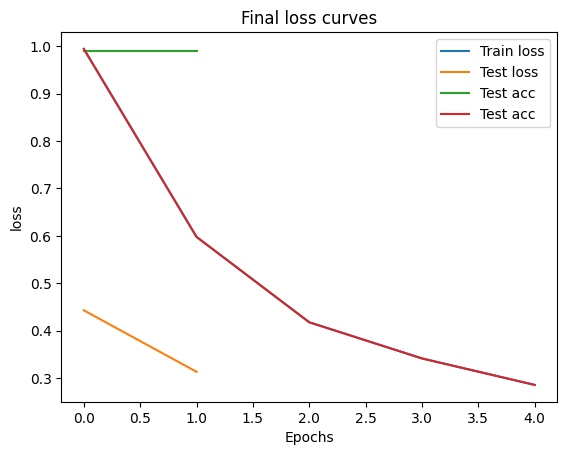

In [70]:
    plt.plot([i for i in range(len(final_training_loss))], np.array(torch.tensor(final_training_loss).cpu().detach().numpy()), label="Train loss") # Detach from computation graph and move to CPU before plotting
    plt.title("Training loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Similarly, detach and move to CPU for other plotting calls
    plt.plot([i for i in range(len(final_testing_loss))], np.array(torch.tensor(final_testing_loss).cpu().detach().numpy()), label="Test loss")
    plt.title("test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.plot([i for i in range(len(test_acc))], np.array(torch.tensor(test_acc).cpu().detach().numpy()), label="Test acc")
    plt.title("test acc curves")
    plt.ylabel("acc")
    plt.xlabel("Epochs")
    plt.legend()

    print("final_training_loss", final_training_loss)
    print("final_testing_loss", final_testing_loss)
    print("train_acc", train_acc)
    print("test_acc", test_acc)

    plt.plot([i for i in range(len(final_training_loss))], np.array(torch.tensor(final_training_loss).cpu().detach().numpy()), label="Test acc")
    plt.title("Final loss curves")
    plt.ylabel("loss")
    plt.xlabel("Epochs")
    plt.legend()

Predicted class: tensor([[2, 6, 0, 2, 3, 6, 0, 6, 4, 2, 0, 6, 0, 6, 2, 3, 0, 2, 2, 2, 7, 0, 0, 4,
         7, 7, 7, 2]])


<ipython-input-63-4923999120fd>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_patched = self.patcher(torch.tensor(x,dtype = torch.float32))


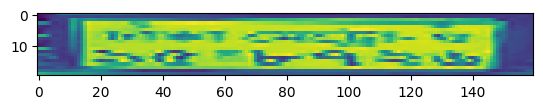

In [71]:
img = cv2.imread(os.path.normpath("/content/drive/MyDrive/Colab Notebooks/test/110_78_1_jpg.rf.d7fe68d3205b26fe2a8f82ec749245d3.jpg"), cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (img_width, img_height))
plt.imshow(img)
img = torch.tensor(img)
img = img.unsqueeze(0).unsqueeze(0)
with torch.no_grad():  # Disable gradient calculations during inference
    predictions = model(img)
    _, predicted_class = torch.max(predictions, 1)
print("Predicted class:", predicted_class)

